# Clase 6: Transfer Learning

---

Jueves 12 de Octubre de 2023

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

### Procesamiento de datos

In [48]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


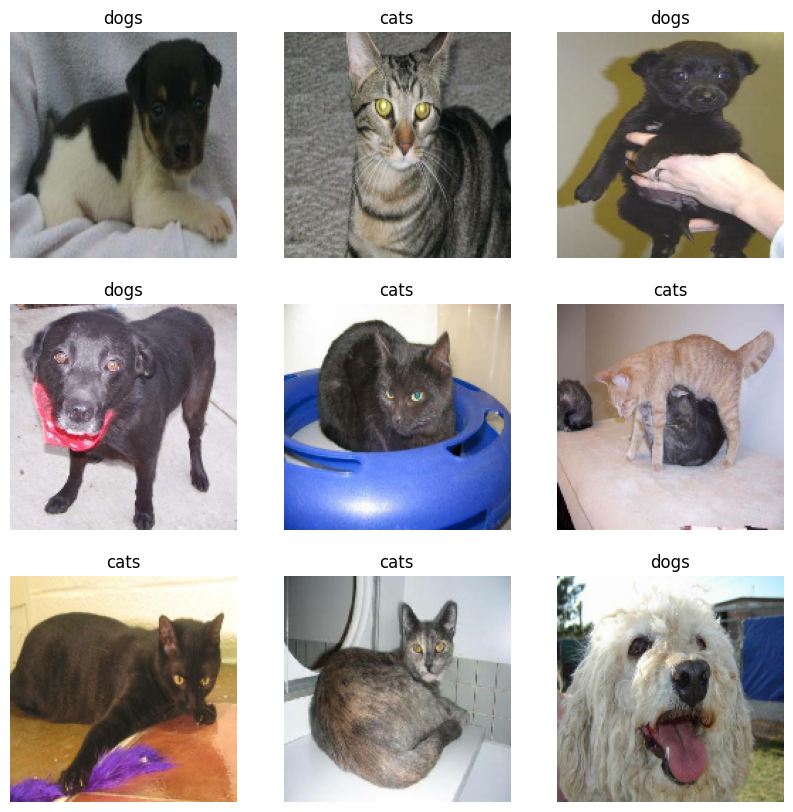

In [49]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [50]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

print('Number of validation batches for validation_dataset: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of validation batches for test_dataset: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches for validation_dataset: 26
Number of validation batches for test_dataset: 6


In [51]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [52]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

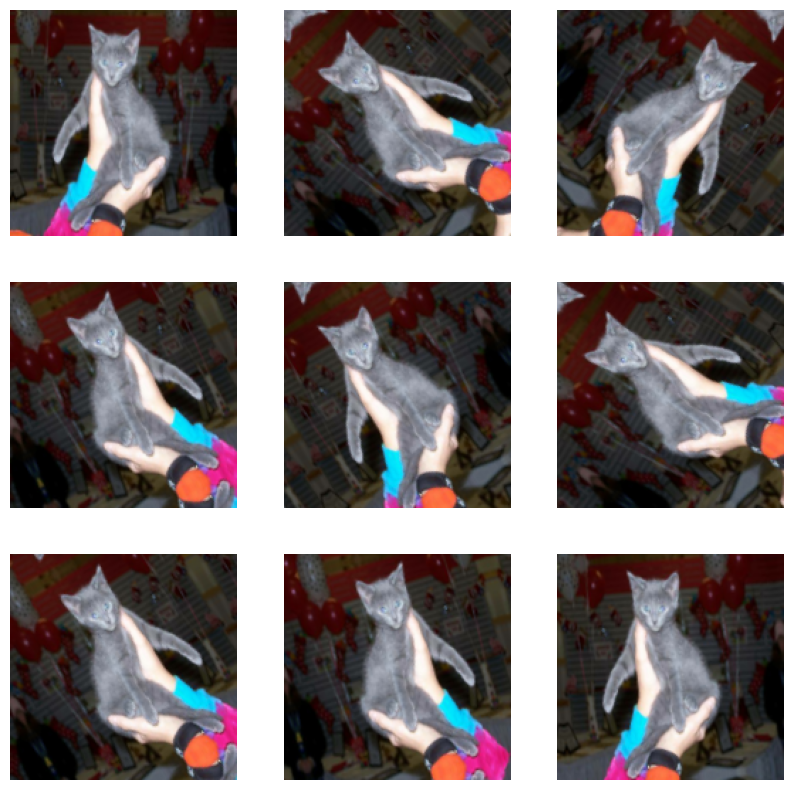

In [53]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [54]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Cargar la red pre-entrenada (MobileNet V2)

In [55]:
# Aumentamos la dimensionalidad de las imagenes (se agregan los canales de color)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE) # (160, 160, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

(160, 160, 3)


In [56]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape) # (32, 5, 5, 1280)
# Arreglo de 32 imágenes de 5x5 con 1280 canales de color

(32, 5, 5, 1280)


In [57]:
# Congelamos la base
base_model.trainable = False

In [58]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [59]:
# Convertimos la imagen de 5x5 a imagen de 1x1

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape) # (32, 1280)

(32, 1280)


In [60]:
# Salida de nuestra red neuronal

prediction_layer = tf.keras.layers.Dense(1) # 1 neurona de salida porque es un problema de clasificación binaria
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape) # (32, 1)

(32, 1)


### Unimos la red pre-entrenada con nuestra red

In [61]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) # Modelo preentrenado congelado
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x) # Dropout para evitar overfitting
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compilamos el modelo

In [62]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [63]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

print('Initial loss: {:.2f}'.format(loss0))
print('Initial accuracy: {:.2f}'.format(accuracy0))

26/26 [==============================] - 4s 91ms/step - loss: 1.0140 - accuracy: 0.3292
Initial loss: 1.01
Initial accuracy: 0.33


In [64]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 12s 159ms/step - loss: 0.4085 - accuracy: 0.7805 - val_loss: 0.1468 - val_accuracy: 0.9344
Epoch 2/10
63/63 [==============================] - 10s 159ms/step - loss: 0.1846 - accuracy: 0.9180 - val_loss: 0.0914 - val_accuracy: 0.9666
Epoch 3/10
63/63 [==============================] - 9s 134ms/step - loss: 0.1515 - accuracy: 0.9415 - val_loss: 0.0767 - val_accuracy: 0.9752
Epoch 4/10
63/63 [==============================] - 9s 135ms/step - loss: 0.1406 - accuracy: 0.9435 - val_loss: 0.0659 - val_accuracy: 0.9802
Epoch 5/10
63/63 [==============================] - 9s 137ms/step - loss: 0.1318 - accuracy: 0.9445 - val_loss: 0.0617 - val_accuracy: 0.9802
Epoch 6/10
63/63 [==============================] - 10s 161ms/step - loss: 0.1237 - accuracy: 0.9485 - val_loss: 0.0626 - val_accuracy: 0.9715
Epoch 7/10
63/63 [==============================] - 9s 140ms/step - loss: 0.1202 - accuracy: 0.9505 - val_loss: 0.0540 - val_accuracy: 0.9827
Epo

Text(0.5, 1.0, 'Training and Validation Accuracy')

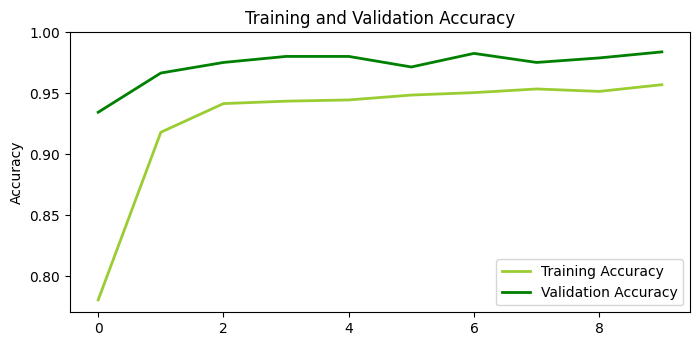

In [65]:
# Gráfica de la precisión

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='yellowgreen', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', color='green', linewidth=2)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')


### Fine Tuning

In [66]:
base_model.trainable = True # Descongelamos la base
print('Number of layers in the base model: ', len(base_model.layers))

Number of layers in the base model:  154


In [67]:
fine_tune_at = 100 # Congelamos las primeras 100 capas
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [68]:
# Compilamos nuevamente el modelo

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [69]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 17s 231ms/step - loss: 2.2319 - accuracy: 0.4835 - val_loss: 0.7027 - val_accuracy: 0.4988
Epoch 11/20
63/63 [==============================] - 13s 213ms/step - loss: 0.9346 - accuracy: 0.5135 - val_loss: 0.7324 - val_accuracy: 0.5012
Epoch 12/20
63/63 [==============================] - 14s 216ms/step - loss: 0.9117 - accuracy: 0.5130 - val_loss: 0.6928 - val_accuracy: 0.4864
Epoch 13/20
63/63 [==============================] - 13s 206ms/step - loss: 0.8878 - accuracy: 0.4930 - val_loss: 0.7582 - val_accuracy: 0.5074
Epoch 14/20
63/63 [==============================] - 13s 203ms/step - loss: 0.8762 - accuracy: 0.4910 - val_loss: 0.7506 - val_accuracy: 0.4963
Epoch 15/20
63/63 [==============================] - 15s 231ms/step - loss: 0.8417 - accuracy: 0.4925 - val_loss: 0.7189 - val_accuracy: 0.5050
Epoch 16/20
63/63 [==============================] - 14s 217ms/step - loss: 0.7976 - accuracy: 0.5060 - val_loss: 0.8536 - val_accuracy: 0.5025
Epoc

Text(0.5, 1.0, 'Training and Validation Accuracy')

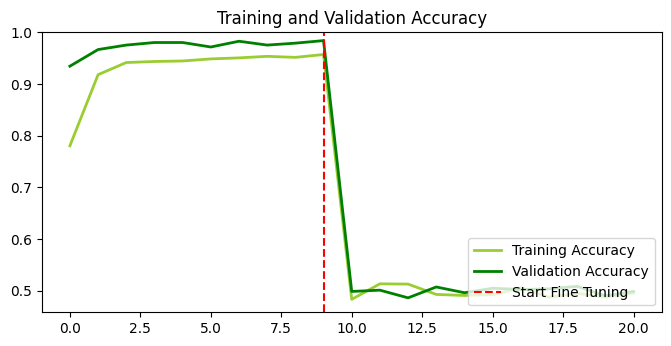

In [70]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='yellowgreen', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', color='green', linewidth=2)
plt.ylim([min(plt.ylim()), 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning', color = 'red', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
